In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [4]:
def Plot_curve(X,Y_arr,Y_legends,
                X_label,Y_label,
                xticks,xtickslabel,
                title,marker_list,linestyle_list,
                ylim=10,dpi=300):
    #Plot parameters
    figsize = (8,7)
    fonttype = "Helvetica"
    fontsize = 9
    grid_linewidth = 0.8
    plot_linewidth = 1.5
    colors_list = ['tab:blue']*3+['tab:red']*3+['tab:orange']+['tab:green']
    savename = "results/"+str(title)+".jpg"

    plt.figure(figsize=figsize)
    for idx in range(np.shape(Y_arr)[1]):
        plt.plot(X,Y_arr[:,idx],label=Y_legends[idx],
                    color=colors_list[idx],
                    marker=marker_list[idx],
                    linestyle=linestyle_list[idx], linewidth=plot_linewidth)

    plt.xticks(xticks,xtickslabel,fontproperties = fonttype, size = fontsize)
    # plt.yticks(yticks,ytickslabel,fontproperties = fonttype, size = fontsize)
    plt.rcParams["font.family"] = fonttype
    plt.rcParams.update({'font.size': fontsize})
    plt.title(title)
    plt.ylim(-ylim,ylim)
    plt.ylabel(Y_label, fontdict={'family' : fonttype, 'size' : fontsize})
    plt.xlabel(X_label, fontdict={'family' : fonttype, 'size' : fontsize})
    plt.legend()
    plt.grid(linewidth=grid_linewidth, alpha=0.3)
    plt.savefig(savename,dpi=dpi)
    plt.tight_layout()
    plt.show()

In [5]:
def str2complex(s):
        str = s.replace(" ","").replace("i","j")
        return complex(str)

Plot coupling under mode number nonconservation

In [6]:
import math
def lcm(a, b):
    return abs(a*b) // math.gcd(a, b)

In [7]:
c  = 3*10**8
mm = 1e-3
# n  = 1
n  = 1.99

In [8]:
L1      = 9.5 * mm
L2      = 9.5 * 1.001 * mm
D1      = c/(n**2 * L1) *2* np.pi
D2      = c/(n**2 * L2) *2* np.pi
D_ave   = (D1 + D2) /2
# D_ave = D1 * 0.99
epsilon = (L2-L1)/(L1+L2)
g       = 1
L       = 0.3

In [9]:
D_ave/(2*np.pi)

7970297130.99084

In [10]:
FSR = (D1-D2)/(2*epsilon)
M = 1/(2*epsilon)
M

1000.5000000000955

In [11]:
num_of_pts = 100
max_idx= 2
X = np.linspace(-max_idx*M,max_idx*M,num_of_pts).reshape(-1,1)
np.shape(X)

(100, 1)

In [12]:
M0 = 0
Y_legends = []

Y_data = np.array(D1 * (X - M0))
Y_legends.append(r"Ring1 $\omega = \omega_0$+$(D_1-\bar{D})$(m-$M_0$)")
for mx in range(1,2):
    Y = D1 * (X - M0) + FSR
    Y_data = np.c_[Y_data,Y]
    Y_legends.append(r"Ring1 $\omega$ = $\omega_0$+$(D_1-\bar{D})$(m-$M_0$)+"+"FSR")
    Y = D1 * (X - M0) - FSR
    Y_data = np.c_[Y_data,Y]
    Y_legends.append(r"Ring1 $\omega$ = $\omega_0$+$(D_1-\bar{D})$(m-$M_0$)-"+"FSR")

Y = D2 * (X - M0)
Y_data = np.c_[Y_data,Y]
Y_legends.append(r"Ring2 $\omega = \omega_0$+$(D_2-\bar{D})$(m-$M_0$)")
for my in range(1,2):
    Y = D2 * (X - M0) +  FSR
    Y_data = np.c_[Y_data,Y]
    Y_legends.append(r"Ring2 $\omega$ = $\omega_0$+$(D_2-\bar{D})$(m-$M_0$)+"+"FSR")
    Y = D2 * (X - M0) -  FSR
    Y_data = np.c_[Y_data,Y]
    Y_legends.append(r"Ring2 $\omega$ = $\omega_0$+$(D_2-\bar{D})$(m-$M_0$)-"+"FSR")

Y_data = Y_data - D_ave * (X - M0)
Y_p = D2/(2*np.pi)*np.arccos(np.cos(g*L)*np.cos(2*np.pi * epsilon *X))
Y_m = -D2/(2*np.pi)*np.arccos(np.cos(g*L)*np.cos(2*np.pi * epsilon *X))
Y_legends.append(r"supermode1 $\omega_{+}$")
Y_legends.append(r"supermode1 $\omega_{-}$")
Y_data = np.c_[Y_data,Y_p,Y_m]
np.shape(Y_data)

(100, 8)

In [13]:
xticks       = np.arange(-max_idx,max_idx+1)
xtickslabels = [("$M_0$+" if xtick>0 else "$M_0$") + str(xtick) + "M"  for xtick in xticks]
xtickslabels[int(len(xtickslabels)/2)] = "$M_0$"
xticks       = np.arange(-max_idx,max_idx+1)*M
# xtickslabels = np.c_[xtickslabels,""]
xtickslabels

['$M_0$-2M', '$M_0$-1M', '$M_0$', '$M_0$+1M', '$M_0$+2M']

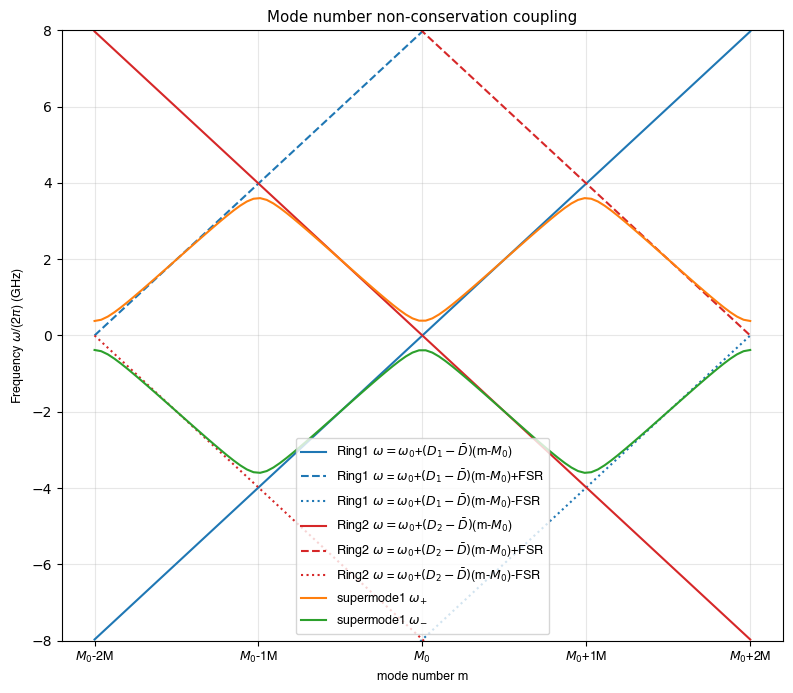

In [14]:
Plot_curve(X,Y_data*1e-9/(2*np.pi),
            Y_legends=Y_legends,
            X_label='mode number m',Y_label=r"Frequency $\omega$/(2$\pi$) (GHz)",
            xticks=xticks,
            xtickslabel=xtickslabels,
            title = "Mode number non-conservation coupling",
            marker_list=["","","","","","","","",".","."]*2,
            linestyle_list=["-","--","dotted","-","--","dotted","-","-"]*2,
            ylim = 8)


In [15]:
# field_coefficients = [A,B]     E_supermode = A * E_1 + B * E_2
# E_1,E_2 are the eigenmodes of separate WGs. A,B are the coefficients
def Plot_field_profile(field,field_name,Plot_log = False,
                    save_name='./results/field_supermode_profile.png',dpi=600):
    fonttype = "Helvetica"
    fontsize = 4
    grid_linewidth = 1
    colormap = "jet"
    figsize =  (15,5)

    fig, ax = plt.subplots(1,3,figsize=figsize,dpi=dpi)
    plt.subplots_adjust(left=0.05, right=0.95, wspace =0.1, hspace =0.2)   #调整子图间距

    name_list = ['Abs','Re','Im']

    field_list = [np.abs(field),np.real(field),np.imag(field)]
    if Plot_log:
        field_list[0] = np.log(field_list[0])
    # Converting the unit of ticks to um
    yticks_prev = np.linspace(0,np.shape(field)[0],10)
    xticks_prev = np.linspace(0,np.shape(field)[1],10)
    xticks,yticks = self.Convert_ticks(xticks_prev,yticks_prev)

    for idx in range(3):
        # Plot the field profile
        im = ax[idx].imshow(field_list[idx], cmap=colormap)
        # Plot the boundaries of the WGs
        ax[idx].plot(WG1_x_arr,WG1_y_arr,color='black', linewidth=0.1)
        ax[idx].plot(WG2_x_arr,WG2_y_arr,color='black', linewidth=0.1)

        ax[idx].set_title(name_list[idx]+'('+field_name+')')
        cbar = fig.colorbar(im, ax=ax[idx], orientation='vertical',
                            label='', shrink=0.3, pad=0.02)
        ax[idx].set_xticks(xticks_prev)
        ax[idx].set_xticklabels(xticks)
        ax[idx].set_yticks(yticks_prev)
        ax[idx].set_yticklabels(yticks)
        ax[idx].set_xlabel("X(um)",fontsize=4)
        ax[idx].set_ylabel("Y(um)",fontsize=4)
        ax[idx].invert_yaxis()
        ax[idx].tick_params(axis='both',labelsize=5)

    plt.rcParams["font.family"] = fonttype
    plt.rcParams.update({'font.size': fontsize})
    plt.legend()

    plt.savefig(save_name,dpi=dpi)
    plt.close()
    # plt.show()
    return